In [ ]:
# Clone directory
! git clone https://github.com/openai/point-e

fatal: destination path 'point-e' already exists and is not an empty directory.


In [1]:
# Re-direct directory for pip install
%cd point-e

d:\ai\point-e


In [2]:
pip install -e .

Obtaining file:///D:/ai/point-eNote: you may need to restart the kernel to use updated packages.
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Cloning https://github.com/openai/CLIP.git to c:\users\jan\appdata\local\temp\pip-install-crieexgh\clip_3a4a86853e2f4226995962394745eda4
  Resolved https://github.com/openai/CLIP.git to commit a9b1bf5920416aaeaec965c25dd9e8f98c864f16
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Attempting uninstall: point-e
    Found existing installation: point-e 0.0.0
    Uninstalling point-e-0.0.0:
      Successfully uninstalled point-e-0.0.0
  Running setup.py develop for point-e



  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git 'C:\Users\Jan\AppData\Local\Temp\pip-install-crieexgh\clip_3a4a86853e2f4226995962394745eda4'

[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: C:\Users\Jan\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [3]:
import torch
from tqdm.auto import tqdm

from point_e.diffusion.configs import DIFFUSION_CONFIGS, diffusion_from_config
from point_e.diffusion.sampler import PointCloudSampler
from point_e.models.download import load_checkpoint
from point_e.models.configs import MODEL_CONFIGS, model_from_config
from point_e.util.plotting import plot_point_cloud

C:\Users\Jan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('creating base model...')
base_name = 'base40M-textvec'
base_model = model_from_config(MODEL_CONFIGS[base_name], device)
base_model.eval()
base_diffusion = diffusion_from_config(DIFFUSION_CONFIGS[base_name])

print('creating upsample model...')
upsampler_model = model_from_config(MODEL_CONFIGS['upsample'], device)
upsampler_model.eval()
upsampler_diffusion = diffusion_from_config(DIFFUSION_CONFIGS['upsample'])

print('downloading base checkpoint...')
base_model.load_state_dict(load_checkpoint(base_name, device))

print('downloading upsampler checkpoint...')
upsampler_model.load_state_dict(load_checkpoint('upsample', device))

creating base model...


100%|███████████████████████████████████████| 890M/890M [03:46<00:00, 4.12MiB/s]


creating upsample model...
downloading base checkpoint...


100%|██████████| 161M/161M [02:12<00:00, 1.22MiB/s]   


downloading upsampler checkpoint...


100%|██████████| 162M/162M [00:55<00:00, 2.93MiB/s] 


<All keys matched successfully>

In [5]:
sampler = PointCloudSampler(
    device=device,
    models=[base_model, upsampler_model],
    diffusions=[base_diffusion, upsampler_diffusion],
    num_points=[1024, 4096 - 1024],
    aux_channels=['R', 'G', 'B'],
    guidance_scale=[3.0, 0.0],
    model_kwargs_key_filter=('texts', ''), # Do not condition the upsampler at all
)

In [6]:
# Set a prompt to condition on.
prompt = 'a green bottle'

# Produce a sample from the model.
samples = None
for x in tqdm(sampler.sample_batch_progressive(batch_size=1, model_kwargs=dict(texts=[prompt]))):
    samples = x

130it [00:17,  7.54it/s]


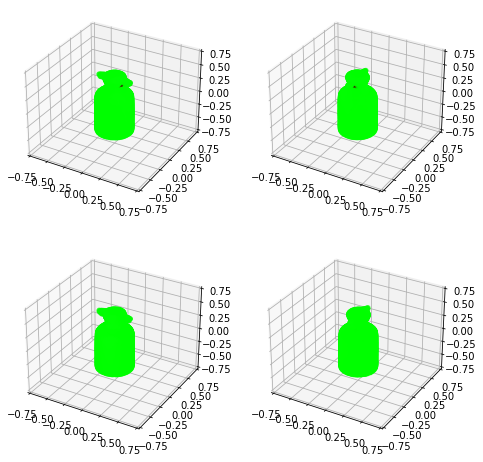

In [7]:
pc = sampler.output_to_point_clouds(samples)[0]
fig = plot_point_cloud(pc, grid_size=2, fixed_bounds=((-0.75, -0.75, -0.75),(0.75, 0.75, 0.75)))

In [9]:
pc.save('model.npz')

In [10]:
! pip install plotly -q


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: C:\Users\Jan\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [12]:
import plotly.graph_objects as go

In [14]:
fig_plotly = go.Figure(
        data=[
            go.Scatter3d(
                x=pc.coords[:,0], y=pc.coords[:,1], z=pc.coords[:,2],
                mode='markers',
                marker=dict(
                    size=2,
                    color=['rgb({},{},{})'.format(r,g,b) for r,g,b in zip(pc.channels["R"], pc.channels["G"], pc.channels["B"])],
                )
            )
        ],
        layout=dict(
            scene=dict(
                xaxis=dict(visible=False),
                yaxis=dict(visible=False),
                zaxis=dict(visible=False)
            )
        ),
    )

In [15]:
from PIL import Image
import torch
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from point_e.models.download import load_checkpoint
from point_e.models.configs import MODEL_CONFIGS, model_from_config
from point_e.util.pc_to_mesh import marching_cubes_mesh
from point_e.util.plotting import plot_point_cloud
from point_e.util.point_cloud import PointCloud

In [21]:
fig_plotly.show(renderer="browser")

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('creating SDF model...')
name = 'sdf'
model = model_from_config(MODEL_CONFIGS[name], device)
model.eval()

print('loading SDF model...')
model.load_state_dict(load_checkpoint(name, device))

creating SDF model...
loading SDF model...


100%|██████████| 38.0M/38.0M [00:09<00:00, 4.18MiB/s]


<All keys matched successfully>

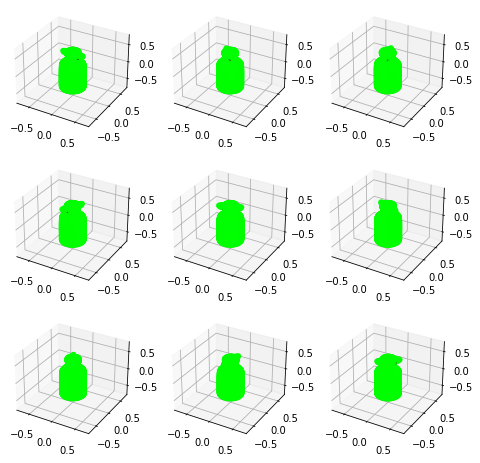

In [18]:
# Load a point cloud we want to convert into a mesh.
pc = PointCloud.load('MyModel.npz')

# Plot the point cloud as a sanity check.
fig = plot_point_cloud(pc, grid_size=3)

In [19]:
from skimage import measure

# Produce a mesh (with vertex colors)
mesh = marching_cubes_mesh(
    pc=pc,
    model=model,
    batch_size=4096,
    grid_size=32, # increase to 128 for resolution used in evals
    progress=True,
)

100%|██████████| 8/8 [00:00<00:00, 286.41it/s]


In [20]:
# Write the mesh to a PLY file to import into some other program.
with open('MyModel.ply', 'wb') as f:
    mesh.write_ply(f)